## Predictors of Domestic Violence in Washington, D.C.

Contributors: Seoho Hahm, Allison Lee

### Table of Contents
1. <a href='#prob'>Problem Statement
2. <a href='#sources'>Data Sources</a>
3. <a href='#approach'>Approach</a>
4. <a href='#eda'>Exploratory Data Analysis</a>
5. <a href='#feature'>Feature Selection</a>
6. <a href='#reg'>Regression</a>
7. <a href='#analysis'>Findings and Analysis</a>
8. <a href='#concl'>Conclusions and Recommendations</a>

In [43]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
import sklearn
import statsmodels.stats.outliers_influence as smd
%run ../pyfiles/data_cleaning
%run ../pyfiles/regression

<a id='prob'></a>
### Problem Statement

This analysis seeks to understand which factors are most efficient in predicting domestic violence in cities such as Washington, D.C. 

Specifically, we look at the strength and contribution of different variables to incidents of domestic violence in Washington, D.C., and the potential interactions between variables. 

<a id='sources'></a>
### Data Sources

We use a dataset of 101 features and 431 observations from a study conducted by Caterina Goman from the Urban Institute, "Alcohol Availability, Type of Alcohol Establishment, Distribution Policies, and Their Relationship to Crime and Disorder in the District of Columbia, 2000-2006". Each observation represents a block in Washington, D.C. 

The original dataset is available here: https://www.icpsr.umich.edu/icpsrweb/NACJD/studies/25763/summary

<a id='approach'></a>
### Approach

We take a more statistical approach to this analysis to understand which factors are most efficient at predicting incidents of domestic violence in Washington, D.C. All of our features are continuous. 

We used Cook's D to assess leverage and outliers in our variables. 

We used three different methods for feature selection--recursive feature elimination, domain knowledge / forward selection, and Lasso regression. We ran models on the resulting features and compared model metrics. We selected our final model based on adjusted R squared metric. 

We then checked the residual plots to ensure they met our assumptions of normal distribution and homoscedasticity. 

Finally, we present our main findings and recommendations. 

<a id='eda'></a>
### Exploratory Data Analysis

In [3]:
df_orig = pd.read_csv('../data/data.tsv', sep = '\t')
df = clean_orig_dataset(df_orig)
y = df['AVGDV']
x = pd.read_csv('../data/final.csv')
x.drop('Unnamed: 0', axis = 1, inplace = True)
final_df = x.merge(y, how = 'inner', left_index = True, right_index = True)

<a id='feature'></a>
### Feature Selection

As a first step, we removed redundant and irrelevant features.

One of the key **assumptions** of linear regression is that there is a lienar relationship between the predictor variable and the dependent variable. In the analysis notebook, we tested this assumption with the remaining variables. We had a final subset of six predictor variables.

We then used Cook's D to identify variables that have outliers with high influence over our regression results. We eliminated those outliers from our dataset (i.e. dropped the rows with outlier data). 

In [4]:
cooksddf = cooksd(final_df, list(final_df.columns))
fin = dropping_outliers(list(final_df.columns), final_df, cooksddf)

We scaled the features in order to properly input them into our models. 

In [5]:
# Scale features
X = scale_dataset(fin.drop('AVGDV', axis = 1))
y = fin.AVGDV

**Recursive Feature Elimination**

First, we tried recursive feature elimination. In our case, recursive feature elimination works by recursively selecting smaller and smaller sets of features. The importance of each feature is obtained through the linear regression coefficient attribute (we scaled the features before inputting them in the rfe model). After initially training on the original set of features, the rfe "prunes" the least important features and repeats this process until the desired number of features is reached. 

In [6]:
rfe_df = recursive_feature_elimination(X, y, 4)

In [7]:
rfe_df.corr() > 0.7

,UNEMPL,POV,CONCDIS,PHYSDIS0506
UNEMPL,True,False,True,False
POV,False,True,True,False
CONCDIS,True,True,True,False
PHYSDIS0506,False,False,False,True


In [8]:
# Drop CONCDIS due to multicollinearity
rfe_df.drop('CONCDIS', axis = 1, inplace = True)

**Lasso Regression**

After standardizing our features, we select a subset of features using Lasso Regression (an embedded method). We tried this approach because we are interested in the importance of the features, and there is a high degree of multicollinearity within our features given the size of our dataset. 

In [9]:
lasso_df = run_lasso(final_df, X, y)

In [10]:
lasso_df.corr() > 0.7

,POV,YOUNGPOP,CONCDIS,PHYSDIS0506
POV,True,False,True,False
YOUNGPOP,False,True,True,False
CONCDIS,True,True,True,False
PHYSDIS0506,False,False,False,True


In [11]:
# Drop due to multicollinearity
lasso_df.drop('CONCDIS', axis = 1, inplace = True)

We therefore further removed variables due to multicollinearity. 

**Forward Selection**

In this method, we started with no variables in the model, added variables one-by-one until we reached a limit where one became insignificant. 

In [12]:
final_df.corr()

,VACANTPERCENT,UNEMPL,POV,YOUNGPOP,CONCDIS,PHYSDIS0506,AVGDV
VACANTPERCENT,1.000000,0.405948,0.427032,0.275703,0.450440,-0.113126,0.278359
UNEMPL,0.405948,1.000000,0.655008,0.363905,0.689410,-0.042425,0.338285
POV,0.427032,0.655008,1.000000,0.483592,0.804391,-0.027743,0.519654
YOUNGPOP,0.275703,0.363905,0.483592,1.000000,0.747349,0.257578,0.589011
CONCDIS,0.450440,0.689410,0.804391,0.747349,1.000000,0.092406,0.653725
PHYSDIS0506,-0.113126,-0.042425,-0.027743,0.257578,0.092406,1.000000,0.323959
AVGDV,0.278359,0.338285,0.519654,0.589011,0.653725,0.323959,1.000000


In [13]:
x_forward = np.array(X.loc[:,['YOUNGPOP', 'POV']])
run_model(x_forward, y)

The correlation matrix shows that there are no variables with a correlation coefficient above 0.7.

In [14]:
x_forward = pd.DataFrame(x_forward, columns = ['YOUNGPOP', 'POV'])
x_forward.corr()

,YOUNGPOP,POV
YOUNGPOP,1.000000,0.504914
POV,0.504914,1.000000


<a id='reg'><a/>
### Multiple Linear Regression

We employ multiple linear regression with average incidents of domestic violence over 2005 to 2006 as our dependent variable. Multiple linear regression models make the following assumptions:
 - a linear relationship between the predictor variables and the dependent variable
 - the residuals are normally distributed
 - independent variables are not highly correlated with each other
 - homoscedasticity of the variance of error terms when plotted against independent variables

We run three different models using the three outputs of our feature selection methods. 

We compared the models using the Adjusted R squared metric, which is adjusted for the number of variables in the model. Our findings are summarized below:


In [26]:
res_ref = run_model(rfe_df, np.array(y).reshape(-1, 1))
resid_rfe = res_ref.resid

In [27]:
res_lasso = run_model(lasso_df, np.array(y).reshape(-1,1))
resid_lasso = res_lasso.resid

In [29]:
res_forward = run_model(x_forward, np.array(y).reshape(-1,1))
resid_forward = res_forward.resid

### Check Assumption: Normal Distribution of Residuals

**Recursive Feature Elimination Method**

Visually, the first model violates the assumption of a normal distribution of residuals. 

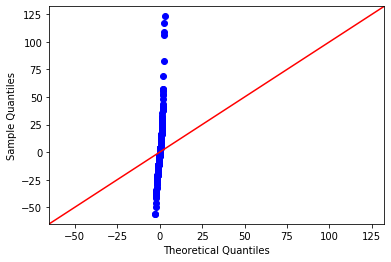

In [30]:
fig = sm.graphics.qqplot(resid_rfe, dist=stats.norm, line='45', fit=True)

In [33]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test_rfe = sms.jarque_bera(resid_rfe)
list(zip(name, test_rfe))

[('Jarque-Bera', 1416.3095098382585),
 ('Prob', 2.833332903258106e-308),
 ('Skew', 1.8688783685044463),
 ('Kurtosis', 11.136193053017985)]

The statistical Jarque-Bera test proves that the rfe model's residuals violate the assumption of normality. The JB value is much higher than 6, and the p-value is very low - which suggests we reject the null hypothesis that errors are normally distributed. 

**Lasso Regression**

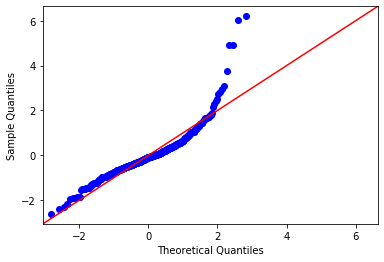

In [35]:
fig = sm.graphics.qqplot(resid_lasso, dist=stats.norm, line='45', fit=True)

In [36]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test_lasso = sms.jarque_bera(resid_lasso)
list(zip(name, test_lasso))

[('Jarque-Bera', 1663.0804369792288),
 ('Prob', 0.0),
 ('Skew', 1.9373468232712103),
 ('Kurtosis', 11.895132244868652)]

For the lasso feature selection, the statistical Jarque-Bera test proves that the lasso model's residuals violate the assumption of normality. The JB value is much higher than 6, and the p-value is very low - which suggests we reject the null hypothesis that errors are normally distributed. 

**Forward Feature Selection**

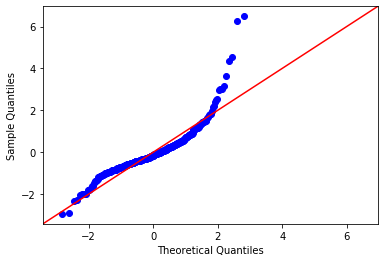

In [38]:
fig = sm.graphics.qqplot(resid_forward, dist=stats.norm, line='45', fit=True)

In [39]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test_forward = sms.jarque_bera(resid_forward)
list(zip(name, test_forward))

[('Jarque-Bera', 1863.8551883135606),
 ('Prob', 0.0),
 ('Skew', 1.960072926250888),
 ('Kurtosis', 12.493876635466968)]

For the forward feature selection, the statistical Jarque-Bera test proves that the forward model's residuals violate the assumption of normality. The JB value is much higher than 6, and the p-value is very low - which suggests we reject the null hypothesis that errors are normally distributed. 

### Check Assumption: Homoscedasticity

### Findings and Analysis

Findings:

 - All of our regression models had adjusted R squared values around 0.4, indicating that our predictor variables weakly predicted incidents of domestic violence. There may be other features that were not included in our dataset that have more predictive power. 
 - However, all of our models violated the assumption that the residuals are normally distributed

